### Cell 1: Imports and Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Utilities
import warnings
import os
import traceback

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.9.1+cpu
CUDA available: False
Using device: cpu


### Cell 2: Data Loading and Preprocessing

In [2]:
def load_and_preprocess_data(file_path):
    print(f"Loading dataset from {file_path}...")
    df = pd.read_csv(file_path)
    
    # Separate Features and Target
    X = df.drop('label', axis=1)
    y = df['label']
    
    # Encode Target Labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Scale Features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split Data (70% Train, 15% Val, 15% Test)
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    print(f"Training Data Shape: {X_train.shape}")
    print(f"Validation Data Shape: {X_val.shape}")
    print(f"Test Data Shape: {X_test.shape}")
    print(f"Number of Classes: {len(le.classes_)}")
    
    return {
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test,
        'scaler': scaler,
        'label_encoder': le,
        'num_classes': len(le.classes_),
        'input_size': X_train.shape[1]
    }

# Load the data
file_path = 'Crop_recommendation.csv'
data_package = load_and_preprocess_data(file_path)

Loading dataset from Crop_recommendation.csv...
Training Data Shape: (1540, 7)
Validation Data Shape: (330, 7)
Test Data Shape: (330, 7)
Number of Classes: 22


### Cell 3: Data Exploration & Analysis

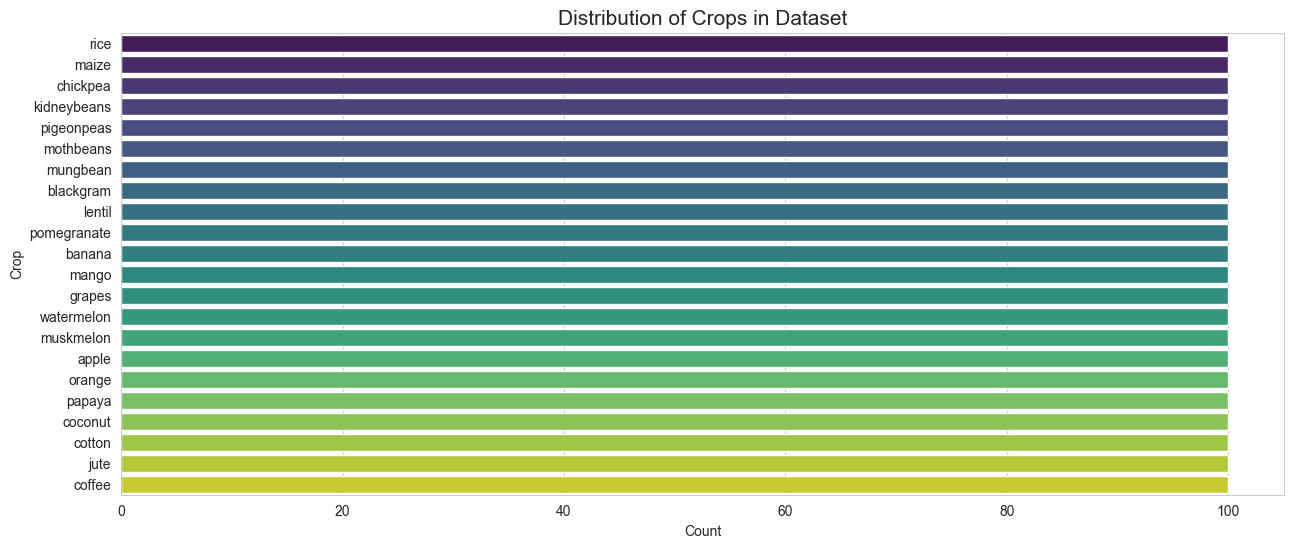

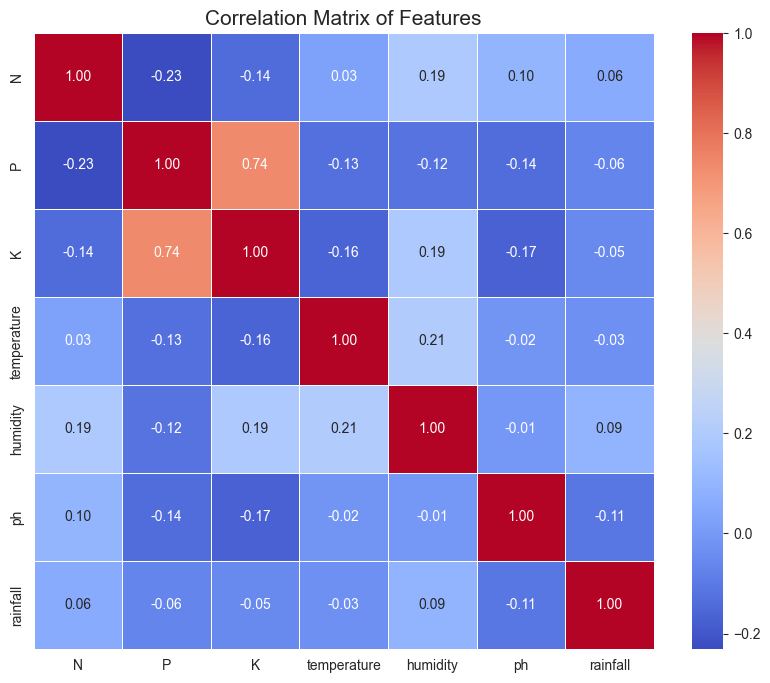

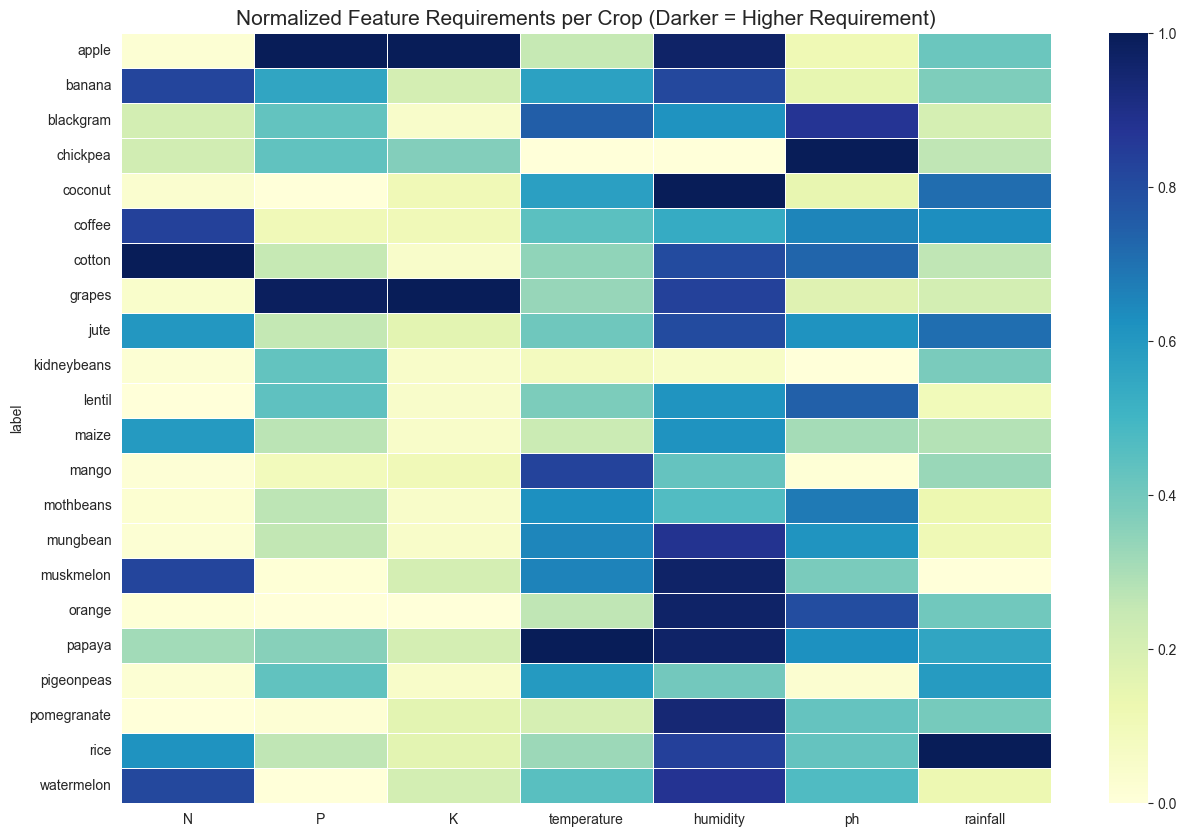

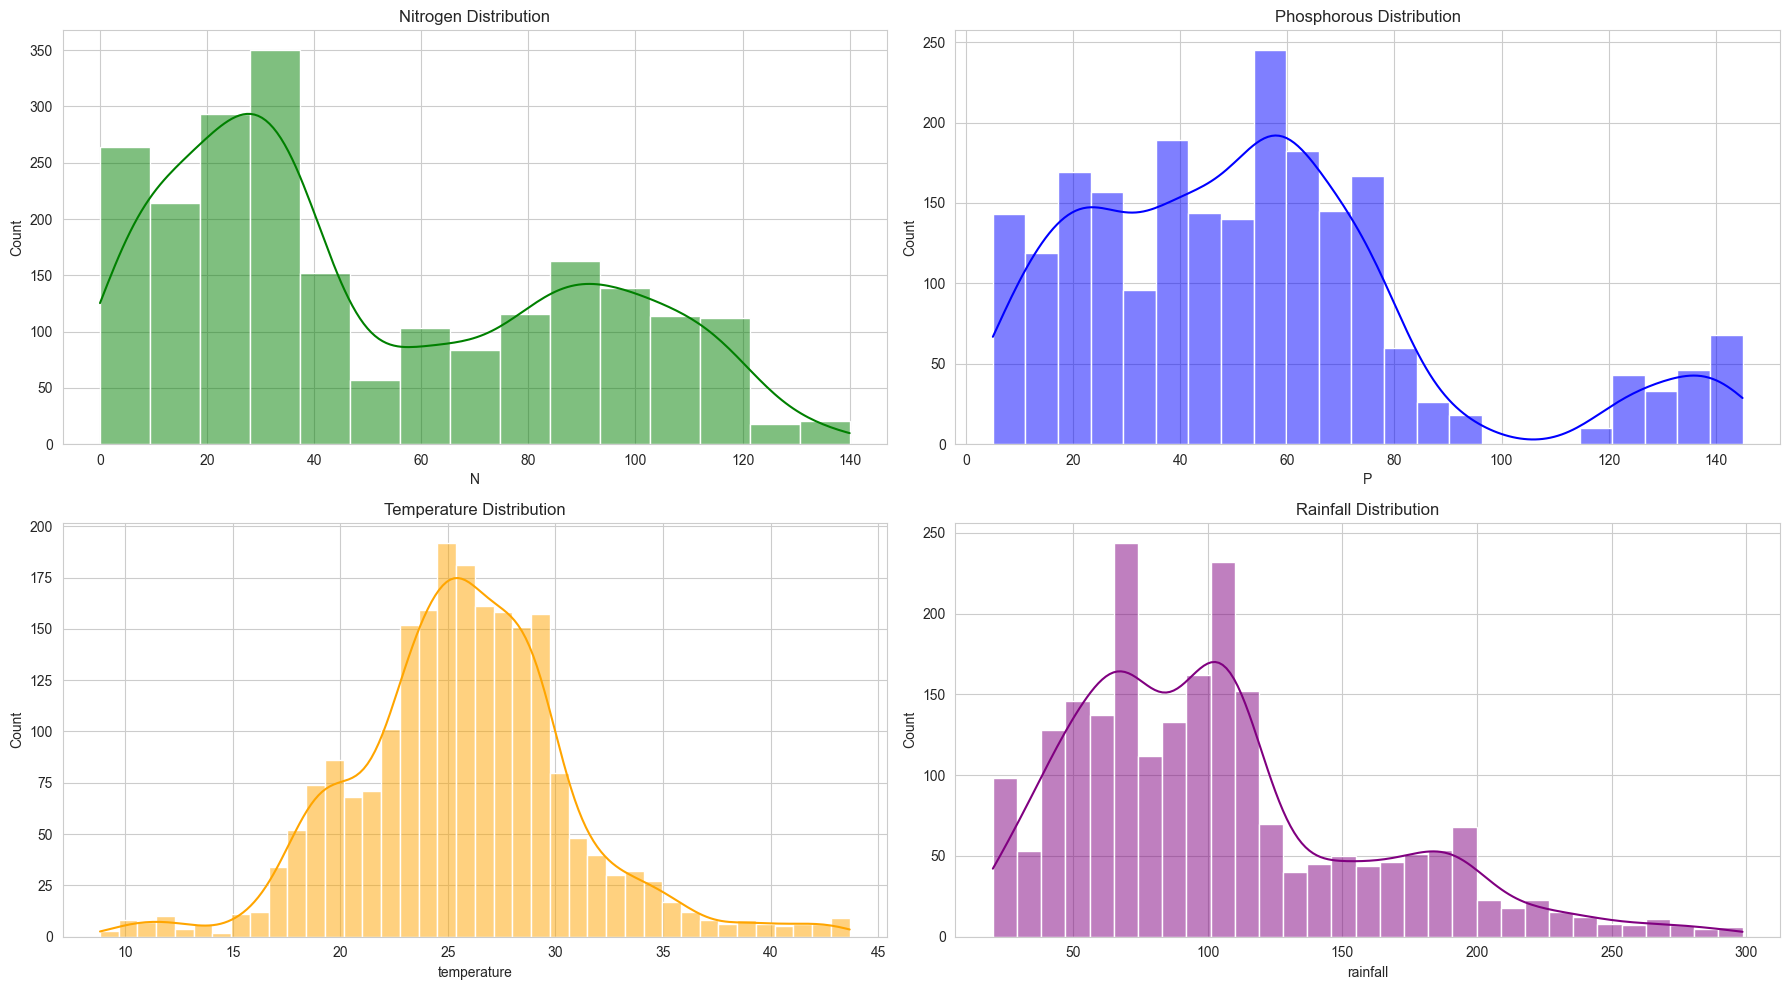

In [3]:
# --- INSERT THIS NEW CELL AFTER CELL 2 ---

# Load a fresh copy for visualization (to keep raw values before scaling)
df_viz = pd.read_csv('Crop_recommendation.csv')

# Set visual style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Check Class Balance
plt.figure(figsize=(15, 6))
sns.countplot(y='label', data=df_viz, palette='viridis', order=df_viz['label'].value_counts().index)
plt.title('Distribution of Crops in Dataset', fontsize=15)
plt.xlabel('Count')
plt.ylabel('Crop')
plt.show()

# 2. Feature Correlation Heatmap
# This shows relationships (e.g., Does high Temp correlate with high Humidity?)
plt.figure(figsize=(10, 8))
# Drop the label column for correlation calculation
correlation = df_viz.drop('label', axis=1).corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Features', fontsize=15)
plt.show()

# 3. Average Requirements per Crop (Pivot Heatmap)
# This is powerful: It shows exactly what soil profile each crop needs
pivot = df_viz.groupby('label').mean()
plt.figure(figsize=(15, 10))
# Normalize data for better color comparison in heatmap
from sklearn.preprocessing import MinMaxScaler
pivot_normalized = pd.DataFrame(MinMaxScaler().fit_transform(pivot), 
                                columns=pivot.columns, 
                                index=pivot.index)

sns.heatmap(pivot_normalized, cmap="YlGnBu", linewidths=0.5)
plt.title('Normalized Feature Requirements per Crop (Darker = Higher Requirement)', fontsize=15)
plt.show()

# 4. Distribution of Key Features
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
sns.histplot(df_viz['N'], kde=True, ax=axes[0,0], color='green').set_title('Nitrogen Distribution')
sns.histplot(df_viz['P'], kde=True, ax=axes[0,1], color='blue').set_title('Phosphorous Distribution')
sns.histplot(df_viz['temperature'], kde=True, ax=axes[1,0], color='orange').set_title('Temperature Distribution')
sns.histplot(df_viz['rainfall'], kde=True, ax=axes[1,1], color='purple').set_title('Rainfall Distribution')
plt.tight_layout()
plt.show()

### Cell 4: PyTorch Dataset Class

In [4]:
class CropDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

def create_dataloaders(data_package, batch_size=32):
    train_dataset = CropDataset(data_package['X_train'], data_package['y_train'])
    val_dataset = CropDataset(data_package['X_val'], data_package['y_val'])
    test_dataset = CropDataset(data_package['X_test'], data_package['y_test'])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = create_dataloaders(data_package)

### Cell 5: Model Definitions

In [5]:
# 1. Improved CNN
class ImprovedCropCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ImprovedCropCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.relu(self.batchnorm2(self.conv2(x)))
        x = self.relu(self.batchnorm3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# 2. Improved LSTM
class ImprovedCropLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(ImprovedCropLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]
        x = self.relu(self.batchnorm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.batchnorm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# 3. Improved GRU with Attention
class ImprovedCropGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(ImprovedCropGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3, bidirectional=True)
        self.attention = nn.Sequential(nn.Linear(hidden_size * 2, 64), nn.Tanh(), nn.Linear(64, 1))
        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.unsqueeze(1)
        gru_out, _ = self.gru(x)
        attn_weights = torch.softmax(self.attention(gru_out), dim=1)
        context = torch.sum(attn_weights * gru_out, dim=1)
        x = self.relu(self.batchnorm1(self.fc1(context)))
        x = self.dropout(x)
        x = self.relu(self.batchnorm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# 4. Transformer
class CropTransformer(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_layers, num_classes):
        super(CropTransformer, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 10, d_model))
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_model * 4, dropout=0.1, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc1 = nn.Linear(d_model, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.embedding(x) * np.sqrt(128)
        x = x + self.pos_encoder[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        x = x[:, -1, :]
        x = self.relu(self.batchnorm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.batchnorm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# 5. Residual MLP
class ResidualMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ResidualMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.res_block1 = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.BatchNorm1d(hidden_size), nn.ReLU(), nn.Dropout(0.3), nn.Linear(hidden_size, hidden_size), nn.BatchNorm1d(hidden_size))
        self.res_block2 = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.BatchNorm1d(hidden_size), nn.ReLU(), nn.Dropout(0.3), nn.Linear(hidden_size, hidden_size), nn.BatchNorm1d(hidden_size))
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(x + self.res_block1(x))
        x = self.dropout(x)
        x = self.relu(x + self.res_block2(x))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        return self.fc3(x)

# 6. Hybrid CNN-LSTM
class HybridCNNLSTM(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HybridCNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, 3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.cnn_bn1 = nn.BatchNorm1d(64)
        self.cnn_bn2 = nn.BatchNorm1d(128)
        self.lstm = nn.LSTM(input_size, 128, 2, batch_first=True, dropout=0.3, bidirectional=True)
        self.fc1 = nn.Linear(128 + 256, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        cnn_x = x.unsqueeze(1)
        cnn_x = self.relu(self.cnn_bn1(self.conv1(cnn_x)))
        cnn_x = self.relu(self.cnn_bn2(self.conv2(cnn_x)))
        cnn_x = self.pool(cnn_x).view(cnn_x.size(0), -1)
        
        lstm_x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(lstm_x)
        lstm_features = lstm_out[:, -1, :]
        
        combined = torch.cat((cnn_x, lstm_features), dim=1)
        x = self.relu(self.batchnorm1(self.fc1(combined)))
        x = self.dropout(x)
        x = self.relu(self.batchnorm2(self.fc2(x)))
        x = self.dropout(x)
        return self.fc3(x)

### Cell 6: Training Function

In [6]:
def train_model(model, train_loader, val_loader, num_epochs=30, model_name="Model"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    
    train_losses, val_accuracies = [], []
    best_acc = 0.0
    
    print(f"--- Training {model_name} ---")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for feats, labels in train_loader:
            feats, labels = feats.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(feats)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for feats, labels in val_loader:
                feats, labels = feats.to(device), labels.to(device)
                outputs = model(feats)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = correct / total
        train_losses.append(running_loss / len(train_loader))
        val_accuracies.append(val_acc)
        
        if val_acc > best_acc:
            best_acc = val_acc
        
        if (epoch+1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Acc: {val_acc:.4f}")
            
    print(f"Best Val Accuracy for {model_name}: {best_acc:.4f}\n")
    return model, train_losses, val_accuracies

### Cell 7: Training Execution

In [7]:
input_size = data_package['input_size']
num_classes = data_package['num_classes']

# Instantiate models
models_to_train = {
    'CNN': ImprovedCropCNN(input_size, num_classes),
    'LSTM': ImprovedCropLSTM(input_size, 128, 2, num_classes),
    'GRU': ImprovedCropGRU(input_size, 128, 2, num_classes),
    'Transformer': CropTransformer(input_size, 128, 4, 3, num_classes),
    'ResidualMLP': ResidualMLP(input_size, 256, num_classes),
    'Hybrid': HybridCNNLSTM(input_size, num_classes)
}

trained_models = {}
model_results = {}

for name, model_obj in models_to_train.items():
    trained_model, t_loss, v_acc = train_model(model_obj, train_loader, val_loader, num_epochs=30, model_name=name)
    trained_models[name] = trained_model
    model_results[name] = {'train_loss': t_loss, 'val_acc': v_acc}

--- Training CNN ---
Epoch [5/30], Loss: 1.0126, Val Acc: 0.9273
Epoch [10/30], Loss: 0.5964, Val Acc: 0.9606
Epoch [15/30], Loss: 0.3550, Val Acc: 0.9788
Epoch [20/30], Loss: 0.3277, Val Acc: 0.9758
Epoch [25/30], Loss: 0.3224, Val Acc: 0.9848
Epoch [30/30], Loss: 0.2833, Val Acc: 0.9848
Best Val Accuracy for CNN: 0.9879

--- Training LSTM ---
Epoch [5/30], Loss: 1.2237, Val Acc: 0.9212
Epoch [10/30], Loss: 0.8419, Val Acc: 0.9727
Epoch [15/30], Loss: 0.5966, Val Acc: 0.9879
Epoch [20/30], Loss: 0.4742, Val Acc: 0.9818
Epoch [25/30], Loss: 0.4464, Val Acc: 0.9909
Epoch [30/30], Loss: 0.3536, Val Acc: 0.9818
Best Val Accuracy for LSTM: 1.0000

--- Training GRU ---
Epoch [5/30], Loss: 1.2307, Val Acc: 0.9394
Epoch [10/30], Loss: 0.8253, Val Acc: 0.9455
Epoch [15/30], Loss: 0.6175, Val Acc: 0.9848
Epoch [20/30], Loss: 0.5208, Val Acc: 0.9758
Epoch [25/30], Loss: 0.4880, Val Acc: 0.9848
Epoch [30/30], Loss: 0.3839, Val Acc: 0.9818
Best Val Accuracy for GRU: 0.9909

--- Training Transforme

### Cell 8: Evaluation and Comparison

In [8]:
def evaluate_models(models, test_loader):
    results = {}
    print("--- Test Set Evaluation ---")
    for name, model in models.items():
        model.eval()
        correct, total = 0, 0
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for feats, labels in test_loader:
                feats, labels = feats.to(device), labels.to(device)
                outputs = model(feats)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        acc = correct / total
        results[name] = acc
        print(f"{name} Test Accuracy: {acc:.4f}")
        
    return results

test_results = evaluate_models(trained_models, test_loader)
best_model_name = max(test_results, key=test_results.get)
print(f"\n🏆 Best Model: {best_model_name} with {test_results[best_model_name]:.4f} accuracy")

# Save the best model
torch.save(trained_models[best_model_name].state_dict(), f"best_model_india_{best_model_name}.pth")
print(f"Saved {best_model_name} to disk.")

--- Test Set Evaluation ---
CNN Test Accuracy: 0.9909
LSTM Test Accuracy: 0.9818
GRU Test Accuracy: 0.9818
Transformer Test Accuracy: 0.8818
ResidualMLP Test Accuracy: 0.9576
Hybrid Test Accuracy: 0.9848

🏆 Best Model: CNN with 0.9909 accuracy
Saved CNN to disk.


### Cell 9: Model Performance Comparison

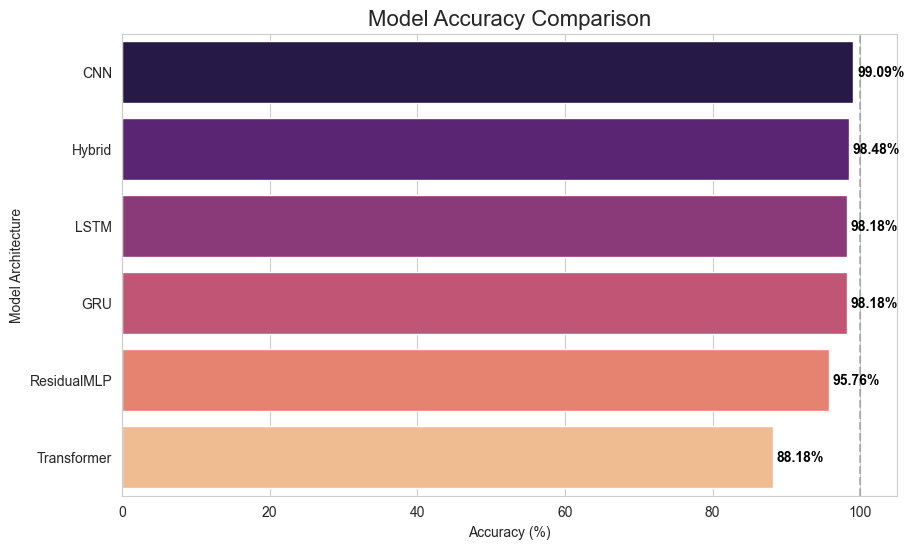

In [9]:
# --- INSERT THIS NEW CELL AFTER CELL 7 ---

def plot_model_performance(results):
    model_names = list(results.keys())
    accuracies = [acc * 100 for acc in results.values()] # Convert to percentage
    
    # Create DataFrame for plotting
    perf_df = pd.DataFrame({
        'Model': model_names,
        'Accuracy': accuracies
    }).sort_values('Accuracy', ascending=False)
    
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(x='Accuracy', y='Model', data=perf_df, palette='magma')
    
    # Add text labels to bars
    for i, v in enumerate(perf_df['Accuracy']):
        barplot.text(v + 0.5, i, f"{v:.2f}%", color='black', va='center', fontweight='bold')
        
    plt.xlim(0, 105) # Give space for text
    plt.title('Model Accuracy Comparison', fontsize=16)
    plt.xlabel('Accuracy (%)')
    plt.ylabel('Model Architecture')
    plt.axvline(x=100, color='grey', linestyle='--', alpha=0.5)
    plt.show()

# Run the visualization using the 'test_results' dictionary from Cell 7
plot_model_performance(test_results)

### Cell 10: Single Prediction Function

In [10]:
def predict_crop(input_data, model, scaler, le):
    """
    input_data: list or numpy array of [N, P, K, temperature, humidity, ph, rainfall]
    """
    model.eval()
    
    # Preprocess Input
    input_array = np.array(input_data).reshape(1, -1)
    scaled_input = scaler.transform(input_array)
    input_tensor = torch.FloatTensor(scaled_input).to(device)
    
    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)
        
    predicted_crop = le.inverse_transform([predicted_idx.item()])[0]
    return predicted_crop, confidence.item()

# Example Prediction
# Input format: [N, P, K, temperature, humidity, ph, rainfall]
sample_input = [90, 42, 43, 20.8, 82.0, 6.5, 202.9] # Example (Rice)

best_model = trained_models[best_model_name]
scaler = data_package['scaler']
le = data_package['label_encoder']

prediction, conf = predict_crop(sample_input, best_model, scaler, le)
print(f"\nInput: {sample_input}")
print(f"Predicted Crop: {prediction} (Confidence: {conf:.2%})")


Input: [90, 42, 43, 20.8, 82.0, 6.5, 202.9]
Predicted Crop: rice (Confidence: 83.33%)


### Cell 11: Save System for Deployment
Bundles the best model, scaler, label encoder, and feature names into a single `.pth` file for the application.

In [11]:
# --- COPY THIS INTO A NEW CELL AT THE END OF YOUR NOTEBOOK ---
import torch
import os

def save_full_system(trained_models, test_results, data_package, best_model_name, filename='india_crop_system.pth'):
    """Bundles everything needed for the App into one file."""
    
    # Move models to CPU before saving to ensure compatibility
    cpu_models = {name: model.cpu().state_dict() for name, model in trained_models.items()}
    
    system_state = {
        'models_state_dict': cpu_models,
        'accuracies': test_results,
        'best_model_name': best_model_name,
        'metadata': {
            'scaler': data_package['scaler'],
            'label_encoder': data_package['label_encoder'],
            'input_size': data_package['input_size'],
            'num_classes': data_package['num_classes'],
            'feature_names': ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'],
            'class_names': data_package['label_encoder'].classes_.tolist()
        }
    }
    
    torch.save(system_state, filename)
    print(f"✅ System saved successfully as '{filename}'")
    print(f"   Contains: {list(cpu_models.keys())}")
    print(f"   Best Model: {best_model_name}")

# Run the save function
# Assuming variables 'trained_models', 'test_results', 'data_package', and 'best_model_name' exist from previous cells
save_full_system(trained_models, test_results, data_package, best_model_name)

✅ System saved successfully as 'india_crop_system.pth'
   Contains: ['CNN', 'LSTM', 'GRU', 'Transformer', 'ResidualMLP', 'Hybrid']
   Best Model: CNN
